In [6]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


In [7]:

from tradeexecutor.monkeypatch.dataclasses_json import patch_dataclasses_json
from tradeexecutor.state.state import State
import requests

# Currently needed because unpatched dataclasses_json package issues
patch_dataclasses_json()

# Public internet endpoint as exposed by the trade executor Docker
webbhook_url = "https://enzyme-polygon-multipair.tradingstrategy.ai/"

state_api = f"{webbhook_url}/state"

resp = requests.get(state_api)
state = State.read_json_blob(resp.text)

print(f"trade-executor was launched at: {state.created_at}, we have {len(list(state.portfolio.get_all_trades()))} trades")

/Users/moo/Library/Caches/pypoetry/virtualenvs/trade-executor-8Oz1GdY1-py3.10/lib/python3.10/site-packages/dataclasses_json/core.py:187: RuntimeWarning: 'NoneType' object value of non-optional type initial_cash detected when decoding TradeSummary.
  warnings.warn(


trade-executor was launched at: 2023-06-23 13:01:41, we have 174 trades


In [55]:
from io import StringIO
from typing import Iterable, List
import pandas as pd

from tradeexecutor.state.position import TradingPosition
from tradeexecutor.state import position 

positions = state.portfolio.closed_positions.values()

data = [(p.closed_at, p.position_id, p.get_realised_profit_percent() * 100, p.is_repaired()) for p in positions]

df = pd.DataFrame(data, columns=("date", "position #", "position profit %", "failed trades"))
df = df.set_index("date")

pd.set_option('display.max_rows', 100)

df

,position #,position profit %,failed trades
date,,,
2023-06-29 13:31:00,1,0.000000,True
2023-06-30 05:36:10,2,0.702420,False
2023-07-03 07:48:02,3,0.000000,True
2023-07-03 07:48:02,4,0.000000,True
2023-07-03 07:48:02,5,0.000000,True
2023-07-03 20:24:09,9,1.704275,False
2023-07-03 22:01:51,6,3.572146,False
2023-07-03 22:58:10,7,0.000000,True
2023-07-03 22:58:10,8,0.000000,True


In [9]:
p = state.portfolio.closed_positions[81]

# print(p)
for t in p.trades.values():
    print(t, t.get_value())



<Buy #161 0.002034988725521271121756101706 WETH at 1563.200885154226, success> 3.1797286351668026
<Sell #162 0 WETH at 1563.200885154226, success> 0.0


## Profit and equity curves

Show different profit and equity charts for diagnostics.

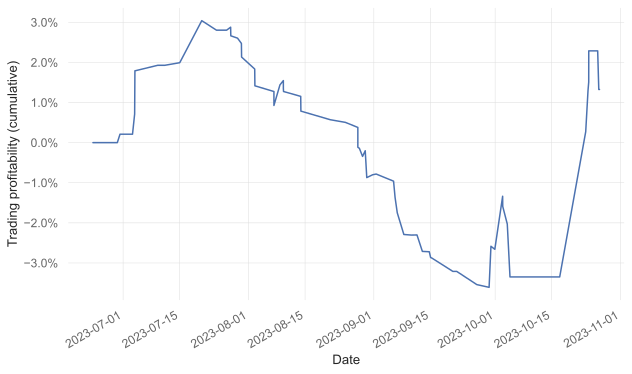

In [32]:
from contextlib import closing
import matplotlib.pyplot as pyplot
import matplotlib.ticker as mtick

from tradeexecutor.visual.equity_curve import calculate_compounding_realised_trading_profitability
from tradeexecutor.utils.notebook import setup_charting_and_output

setup_charting_and_output()

with closing(pyplot) as fig:
    df = calculate_compounding_realised_trading_profitability(state)
    ax = df.plot.line()
    ax.set_xlabel("Date")
    ax.set_ylabel("Trading profitability (cumulative)")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    fig.show()

/var/folders/12/pbc59svn70q_9dfz1kjl3zww0000gn/T/ipykernel_15612/2238087157.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.index.strftime("%Y-%m-%d"))


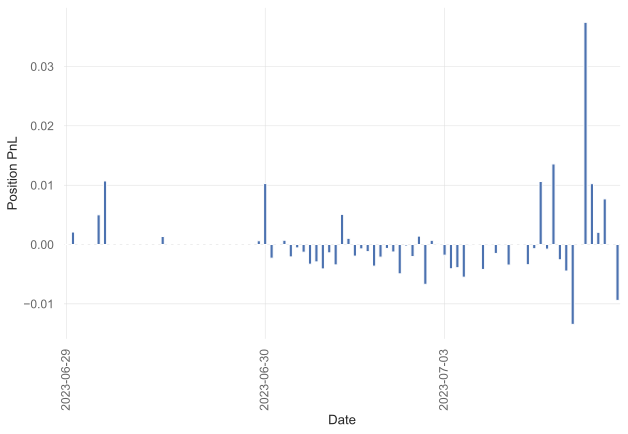

In [51]:
import matplotlib.dates as mdates

from tradeexecutor.visual.equity_curve import calculate_size_relative_realised_trading_returns

with closing(pyplot) as fig:
    df = calculate_size_relative_realised_trading_returns(state)
    ax = df.plot.bar()
    ax.set_xlabel("Date")
    ax.set_ylabel("Position PnL")    
    # ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xticklabels(df.index.strftime("%Y-%m-%d"))
    fig.show()


In [ ]:
import matplotlib.dates as mdates

from tradeexecutor.visual.equity_curve import calculate_size_relative_realised_trading_returns

with closing(pyplot) as fig:
    df = calculate_equity_curve(state)
    ax = df.plot.bar()
    ax.set_xlabel("Date")
    ax.set_ylabel("Position PnL")    
    # ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xticklabels(df.index.strftime("%Y-%m-%d"))
    fig.show()

### Breakpoint
Convert to normal for loop (with enumerate) and set conditional breakpoint here (i == 80). After reaching this breakpoint, the next step is to step into the `get_size_relative_realised_profit_percent` method and go from there.

```python

https://github.com/tradingstrategy-ai/trade-executor/blob/7c74a2ce9443558f7c40abf6675a57bf05a78108/tradeexecutor/visual/equity_curve.py#L366

```python
data = []
for i, p in enumerate(state.portfolio.closed_positions.values()):
    if not p.is_closed():
        continue

    data.append((p.closed_at, p.get_size_relative_realised_profit_percent()))
```

In [10]:
from tradeexecutor.visual.equity_curve import calculate_compounding_realised_trading_profitability

profitability = calculate_compounding_realised_trading_profitability(state)

returns_all_time = profitability.iloc[-1]

print(f"Returns all time: {returns_all_time:.2%}")

Returns all time: 1.33%
